In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mvcl.model import MetaVisualLearner
from mvcl.config import config

from datasets.sprites_base_dataset import SpritesBaseDataset
from rinarak.utils.tensor import logit, stats_summary
from rinarak.program import Program

In [5]:
from rinarak.domain import *
domain_parser = Domain("mvcl/base.grammar")
meta_domain_str = f"""
(domain demo)
(:type
    object - vector[float,100]
    position - vector[float,2]
    color - vector[float, 64]
    category
)
(:predicate
    color ?x-object -> vector[float,100]
    shape ?x-object -> vector[float,100]

    red ?x-color -> boolean
    blue ?x-color -> boolean
    green ?x-color -> boolean
    not-any-color ?x-color -> boolean

    square ?x-shape -> boolean
    circle ?x-shape -> boolean
    diamond ?x-shape -> boolean
    not-any-shape ?x-shape -> boolean
)
(:derived
    is-good ?x-color expr: (??f ?x)

)
(:constraint
    (color: red blue green not-any-color)
    (shape: square circle diamond not-any-shape)
)
"""
domain = load_domain_string(meta_domain_str, domain_parser)

In [6]:
"""Load Dataset Sprite Base"""
from torch.utils.data import DataLoader, Dataset
dataset = SpritesBaseDataset("train")
loader = DataLoader(dataset, batch_size = 1, shuffle = True)

In [7]:
from mvcl.custom import build_custom
config.concept_type = "cone"
#config.concept_dim = 100
print(config.concept_dim)
model = MetaVisualLearner(domain, config)
model = build_custom(model, domain.domain_name)
#model.perception.load_state_dict(torch.load("checkpoints/KFT_percept_backup.pth"))
model.central_executor.load_state_dict(torch.load("checkpoints/KFT_knowledge_backup.pth"))

32


<All keys matched successfully>

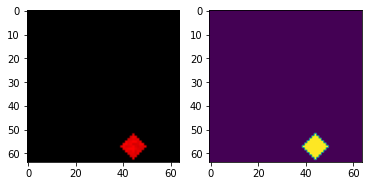

In [13]:
for sample in loader: break
imgs = sample["img"];masks = sample["masks"]
plt.subplot(121);plt.imshow(imgs[0].permute(1,2,0))
plt.savefig("outputs/input_image.png", bbox_inches='tight')
plt.subplot(122);plt.imshow(masks[0])
plt.savefig("outputs/gt_masks.png", bbox_inches='tight')

In [14]:
def to_instance_masks(one_hot_masks):
    ids = torch.unique(one_hot_masks)
    masks = []
    for i in ids:
        masks.append((one_hot_masks == i).unsqueeze(0))
    masks = torch.cat(masks, dim = 1) 
    return masks

all_masks = to_instance_masks(masks)


tensor([1., 1.])


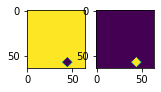

In [15]:
percept_outputs = model.perception(imgs, masks.unsqueeze(0).long())
all_masks = percept_outputs["masks"]

all_masks = to_instance_masks(masks)
all_alives = percept_outputs["alive"]
all_alives = torch.ones(all_masks.shape[:2])

for i in range(all_masks.shape[1]):
    plt.subplot(2,5,1+i);plt.imshow(all_masks[0,i,:,:])
print(all_alives.flatten())

In [16]:
backbone_features = model.implementations["universal"](imgs)
b = 0
context = {
        "end":logit(all_alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
    }

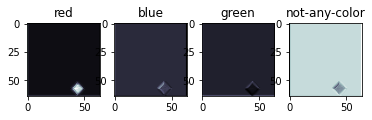

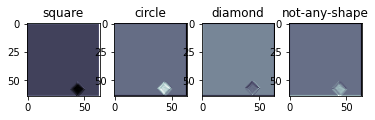

In [52]:
"""Evaluate the Property Map"""
from rinarak.utils.tensor import stats_summary

def visualize_concept_maps(concept_name, features, model):
    import math
    mapper = model.implementations[concept_name]

    concept_feature_map = mapper(features)

    values = model.central_executor.type_constraints[concept_name]

    W = H = int(math.sqrt(concept_feature_map.shape[1]))

    prob_values = []
    for i,value in enumerate(values):
        value_map = model.entailment(concept_feature_map, value).reshape([W,H])
        prob_values.append(value_map.unsqueeze(-1))
        plt.subplot(1, len(values), i+1)
        plt.imshow(value_map.sigmoid().detach(), cmap = "bone")
        plt.title(value)
    prob_values = torch.cat(prob_values, dim = -1)
    #print(prob_values.shape)
    #plt.figure("namo")
    #stats_summary(prob_values.softmax(dim = -1).sum(-1))
    #plt.imshow(prob_values.sigmoid().sum(-1).detach())
    #print(prob_values)
    #print(prob_values.softmax(dim = -1))

#print(context["features"].shape)
visualize_concept_maps("color", context["features"].unsqueeze(0), model)
plt.show()
visualize_concept_maps("shape", context["features"].unsqueeze(0), model)

In [35]:
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
"""Load Dataset Sprite Base"""
class Tetrominoes(Dataset):
    def __init__(self,mode = "images"):
        super().__init__()
        self.path = "/Users/melkor/Documents/datasets/tetrominoes"
        self.resolution = [35,35]
        self.resolution = [64,64]
        self.mode = mode

        self.img_transform = transforms.Compose(
            [transforms.ToTensor()]
        )

    def __len__(self): return 200
        #return len(self.question_file)

    def __getitem__(self,index):
        image = Image.open(os.path.join(self.path,self.mode,"{}.png".format(index)))
        image = image.convert("RGB").resize(self.resolution) 
        image = self.img_transform(image) * 255.0

        return {"image":image.permute([1,2,0])}



class Clevr4(Dataset):
    def __init__(self, stage=0,path = "/Users/melkor/Documents/datasets/clevr4/CLEVR_new_{}.png"):
        super().__init__()
        self.path = path
        #self.images = sorted(glob(self.path))
        self.img_transform = transforms.Compose(
            [transforms.ToTensor()]
        )

    def __len__(self):
        return 200

    def __getitem__(self, index):
        index = "000000" + str(index)
        image = Image.open(self.path.format(index[-6:]))
        image = image.convert("RGB").resize([64,64])
        image = self.img_transform(image)
        sample = {"image":image.permute([1,2,0])}
        return sample

dataset = Clevr4()
dataset = Tetrominoes()
loader = DataLoader(dataset, batch_size = 1, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


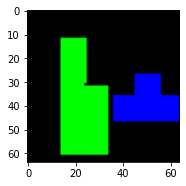

In [49]:
for sample in loader: break
imgs = sample["image"]
plt.subplot(121);plt.imshow(imgs[0])


torch.Size([1, 4, 64, 64])
red


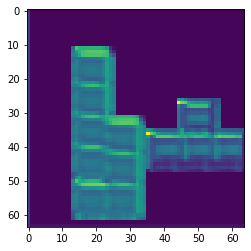

shape:[64, 64] max:1.1278167963027954 min:-4.080021858215332
green


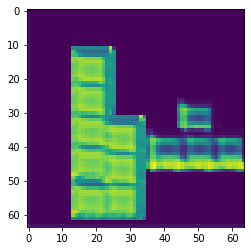

shape:[64, 64] max:1.2768510580062866 min:-3.9826149940490723
blue


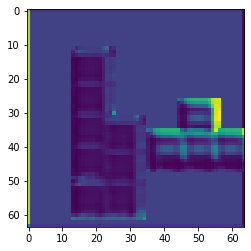

shape:[64, 64] max:0.5736227035522461 min:-3.7162463665008545
not-any-color


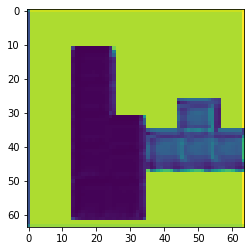

shape:[64, 64] max:2.392364501953125 min:-5.730419158935547


In [51]:
mapper = model.implementations["color"]
input_imgs = imgs.permute(0,3,1,2)
B, D, W, H= input_imgs.shape

cat_im = torch.cat([input_imgs, torch.ones(B,1,W,H)], dim = 1)
print(cat_im.shape)
features = backbone_features = model.implementations["universal"](cat_im)
concept_feature_map = mapper(features)
value_feature_maps = []
import math
W = H = int(math.sqrt(concept_feature_map.shape[1]))
for value in ["red", "green", "blue","not-any-color"]:
    print(value)
    value_map = model.entailment(concept_feature_map, value).reshape([W,H])
    plt.imshow(value_map.sigmoid().detach())
    plt.show()
    stats_summary(value_map)